# Customizing Scanpy plots

This is an advanced tutorial on customizing scanpy plots. For an introduction to `scanpy` plotting functions please see the [introductory tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html).


This tutorial covers
* [Customizing plots](#customization)
    * [Scanpy plot objects](#fig-ax)
    * [Pre-defined matplotlib axes](#mpl-ax)
    * [Plot size](#size)
    * [Space between plots](#gap)
    * [Axes appearance](#pretty-axes)
    * [Legends](#legends)
    * [Highlights and marks on plots](#marks)
    * [Colors and palettes](#colors)
* [UMAP](#umap)    
    * [Coloring-in a subset of cells](#umap-subset)
    * [Ordering of cells](#umap-order)
    * [Optimized UMAP layout](#umap-embed)
* [PAGA](#paga)
    * [Prunning edges](#paga-prune)
    * [Custom layout](#paga-embed)

In [129]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Inital setting for plot size
from matplotlib import rcParams

FIGSIZE = (3, 3)
rcParams["figure.figsize"] = FIGSIZE

In [2]:
adata = sc.datasets.pbmc68k_reduced()

(customization)=
## Adapting matplotlib based plots

This section provides general information on how to customize plots. 

scanpy plots are based on `matplotlib` objects, which we can obtain from `scanpy` functions and subsequently customize. Matplotlib plots are drawn in `Figure` objects which in turn contain one or multiple `Axes` objects. Some `scanpy` functions can also take as an input predefined `Axes`, as shown below.

Please note that some tutorial parts are specific for individual `scanpy` ploting functions, as they create plots in different ways. Certain functions plot on individual `Axes` objects while others use the whole `Figure`, combining multiple `Axes` to display different parts of a single plot. There are also other differences, such as which types of legends are used (i.e. continous `Colorbar` or discrete `Legend`), etc.

(fig-ax)=
### A note on Figures and Axes used in Scanpy plots
`scanpy` plotting functions can return `Figure` or the plot object (by setting `return_fig=True`) or `Axes` (by setting `show=False`). 

The `show` parameter also regulates when the plot is rendered. If we want to customize `Axes` after the `scanpy` plotting function was called we need to set `show=False` to ensure that the plot will be rendered only after we made all adjustments.

For example, from `embedding` plots (such as `umap`) we can obtain either axes (by setting `show=False`) or the whole figure (by setting `return_fig=True`) that stores axes in `figure.axes`. For every plotted category one `Axes` object will be created and for every continuous category two `Axes` objects: the UMAP plot and colorbar on the side. However, if we want to obtain the colorbar axes object we need to use `return_fig=True` rather than `show=False`. When accessing `Axes` from `Figure` the returned object is a list and we need to select the relevant `Axes` to modify them. When returning `Axes` directly (e.g. with `show=False`) we obtain either an individual `Axes` object (if this is the only `Axes` object on the `Figure`) or a list of `Axes` (if multiple `Axes` were created).

In [150]:
# Examples of returned objects from the UMAP function

print("Categorical plots:")
axes = sc.pl.umap(adata, color=["bulk_labels"], show=False)
print("Axis from a single category plot:", axes)
plt.close()
axes = sc.pl.umap(adata, color=["bulk_labels", "S_score"], show=False)
print("Axes list from two categorical plots:", axes)
plt.close()
fig = sc.pl.umap(adata, color=["bulk_labels"], return_fig=True)
print("Axes list from a figure with one categorical plot:", fig.axes)
plt.close()

print("\nContinous plots:")
axes = sc.pl.umap(adata, color=["IGJ"], show=False)
print("Axes from one continuous plot:", axes)
plt.close()
fig = sc.pl.umap(adata, color=["IGJ"], return_fig=True)
print("Axes list from a figure of one continous plot:", fig.axes)
plt.close()

Categorical plots:
Axis from a single category plot: AxesSubplot(0.125,0.125;0.775x0.755)
Axes list from two categorical plots: [<AxesSubplot: title={'center': 'bulk_labels'}, xlabel='UMAP1', ylabel='UMAP2'>, <AxesSubplot: title={'center': 'S_score'}, xlabel='UMAP1', ylabel='UMAP2'>]
Axes list from a figure with one categorical plot: [<AxesSubplot: title={'center': 'bulk_labels'}, xlabel='UMAP1', ylabel='UMAP2'>]

Continous plots:
Axes from one continous plot: AxesSubplot(0.125,0.125;0.70525x0.755)
Axes list from a figure of one continous plot: [<AxesSubplot: title={'center': 'IGJ'}, xlabel='UMAP1', ylabel='UMAP2'>, <AxesSubplot: label='<colorbar>'>]


Certain plots (e.g. `dotplot`) are more complex, having a special plot object with multiple `Axes` that are used to plot different parts of the plot.

In [100]:
axes = sc.pl.dotplot(adata, ["CD79A", "MS4A1"], "bulk_labels", show=False)
print("Axes returned from dotplot object:", axes)
dp = sc.pl.dotplot(adata, ["CD79A", "MS4A1"], "bulk_labels", return_fig=True)
print("DotPlot object:", dp)
plt.close()

Axes returned from dotplot object: {'mainplot_ax': <AxesSubplot: >, 'size_legend_ax': <AxesSubplot: title={'center': 'Fraction of cells\nin group (%)'}>, 'color_legend_ax': <AxesSubplot: title={'center': 'Mean expression\nin group'}>}
DotPlot object: <scanpy.plotting._dotplot.DotPlot object at 0x7f7b7b11a040>


(mpl-ax)=
### Using matplotlib Axes to customize plot alignment
When combining multiple different plots one can pass pre-defined `matplotlib` `Axes` to some plotting functions (e.g. `embedding`). This can be useful when we want to have custom subplot aligmnet or want to show side by side two different plot types or two different data subsets. 

Please also see the note on the `show` parameter above, which is required for figure rendering.

axes: [<AxesSubplot: > <AxesSubplot: >]


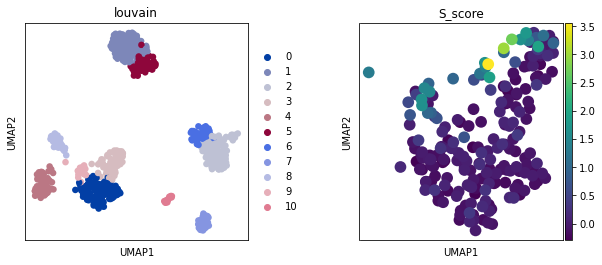

In [148]:
# Define matplotlib Axes
# Number of Axes & plot size
ncols = 2
nrows = 1
figsize = 4
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
# This produces two Axes objects in a single Figure
print("axes:", axs)

# We can use these Axes objects individually to plot on them
# We need to set show=False so that the Figure is not displayed before we
# finished plotting on all Axes and making all plot adjustments
sc.pl.umap(adata, color="louvain", ax=axs[0], show=False)
# Example zoom-in into a subset of louvain clusters
sc.pl.umap(
    adata[adata.obs.louvain.isin(["0", "3", "9"]), :], color="S_score", ax=axs[1]
)

We can also remove some `Axes` from the `Figure`, for example to have different number of columns per row. 

`matplotlib` also enables more advanced Axes alignment customization, such as differently sized `Axes` as shown in [their tutorial](https://matplotlib.org/stable/gallery/userdemo/demo_gridspec03.html#sphx-glr-gallery-userdemo-demo-gridspec03-py) for `GridSpec`.

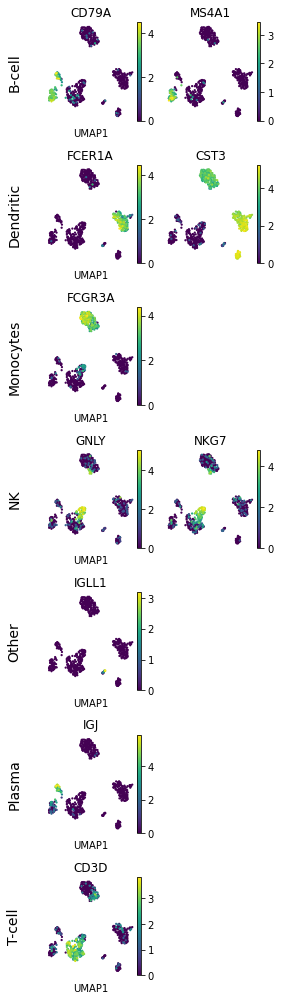

In [20]:
# In this example we want to show UMAPs of different cell type markers,
# with markers of a single cell type in one row
# and with a different number of markers per cell type (row)

# Marker genes
marker_genes = {
    "B-cell": ["CD79A", "MS4A1"],
    "Dendritic": ["FCER1A", "CST3"],
    "Monocytes": ["FCGR3A"],
    "NK": ["GNLY", "NKG7"],
    "Other": ["IGLL1"],
    "Plasma": ["IGJ"],
    "T-cell": ["CD3D"],
}
# Make Axes
# Number of needed rows and columns (based on the row with the most columns)
nrow = len(marker_genes)
ncol = max([len(vs) for vs in marker_genes.values()])
fig, axs = plt.subplots(nrow, ncol, figsize=(2 * ncol, 2 * nrow))
# Plot expression for every marker on the corresponding Axes object
for row_idx, (cell_type, markers) in enumerate(marker_genes.items()):
    col_idx = 0
    for marker in markers:
        ax = axs[row_idx, col_idx]
        sc.pl.umap(adata, color=marker, ax=ax, show=False, frameon=False, s=20)
        # Add cell type as row label - here we simply add it as ylabel of
        # the first Axes object in the row
        if col_idx == 0:
            # We disabled axis drawing in UMAP to have plots without background and border
            # so we need to re-enable axis to plot the ylabel
            ax.axis("on")
            ax.tick_params(
                top="off",
                bottom="off",
                left="off",
                right="off",
                labelleft="on",
                labelbottom="off",
            )
            ax.set_ylabel(cell_type + "\n", rotation=90, fontsize=14)
            ax.set(frame_on=False)
        col_idx += 1
    # Remove unused column Axes in the current row
    while col_idx < ncol:
        axs[row_idx, col_idx].remove()
        col_idx += 1
# Alignment within the Figure
fig.tight_layout()

(size)=
### Plot size
There are multiple options for adjusting plot size, as shown below.

We can adjust plot size by setting `rcParams['figure.figsize']`, which will also change settings for future plots.
These are either available through scanpy's [set_figure_params](https://scanpy.readthedocs.io/en/stable/generated/scanpy._settings.ScanpyConfig.set_figure_params.html#scanpy._settings.ScanpyConfig.set_figure_params) which wraps Matplotlib's rcParams or by modifying them directly.

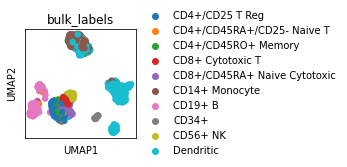

In [130]:
rcParams["figure.figsize"] = (2, 2)
sc.pl.umap(adata, color="bulk_labels")
# Set back to value selected above
rcParams["figure.figsize"] = FIGSIZE

We can set `rcParams` for a single plot with a context manager which won't change the setting for future plots.

/Users/karin.hrovatin/Documents/GitHub/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


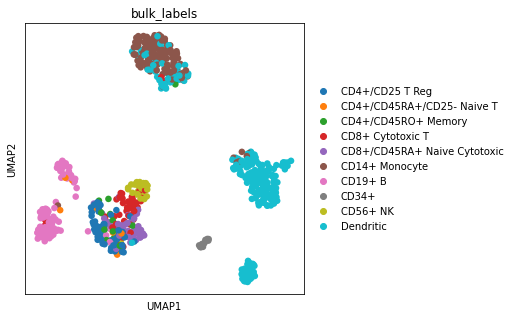

In [35]:
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(adata, color="bulk_labels")

We can also create an `Axes` object with a predefined size and pass it to a `scanpy` plotting function. 

/Users/karin.hrovatin/Documents/GitHub/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


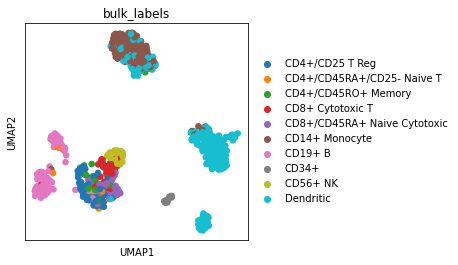

In [42]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(adata, color="bulk_labels", ax=ax)

The `figsize` is divided between all `Axes` and `spaces` between them. Thus, if we have multiple `Axes` (columns or rows) we must accordingly increase `figsize`. 

However, if we do not pass `Axes` objects to the `scanpy` `embedding` function it will automatically create individual `Axes` with the size of the current global `figsize` (as specified by e.g. `matplotlib` `figure.figsize`).

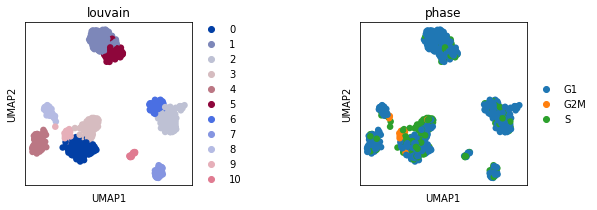

In [149]:
ncol = 2
nrow = 1
figsize = 3
wspace = 1
# Adapt figure size based on number of rows and columns and added space between them
# (e.g. wspace between columns)
fig, axs = plt.subplots(
    nrow, ncol, figsize=(ncol * figsize + (ncol - 1) * wspace * figsize, nrow * figsize)
)
plt.subplots_adjust(wspace=wspace)
sc.pl.umap(adata, color="louvain", ax=axs[0], show=False)
sc.pl.umap(adata, color="phase", ax=axs[1])

(gap)=
### Adjust space between subplots
When plotting multiple plots (e.g. with `embedding`) in the same row or column it may happen that the legend overlaps with the neighbouring plot. This can be overcomed by setting `wspace` (width) or `hspace` (height). These parameters can be likewise used when creating `Axes` for plotting (see the above section on using `matplotlib` `Axes`).

/Users/karin.hrovatin/Documents/GitHub/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/karin.hrovatin/Documents/GitHub/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


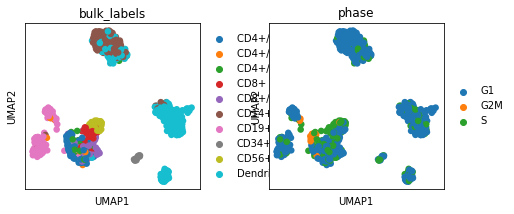

In [43]:
# Default, legend is overlapping
sc.pl.umap(adata, color=["bulk_labels", "phase"])

/Users/karin.hrovatin/Documents/GitHub/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/karin.hrovatin/Documents/GitHub/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


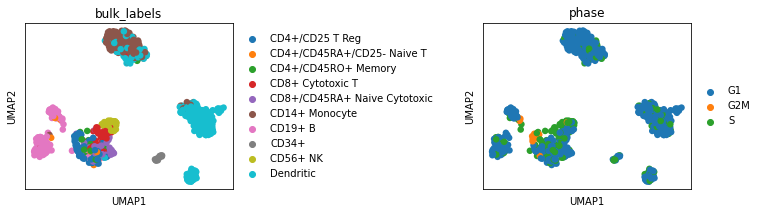

In [73]:
# Increase gap size between plots
sc.pl.umap(adata, color=["bulk_labels", "phase"], wspace=1)

(pretty-axes)=
### Adapt axes appearance

We can further modify the plot object (e.g. `Axes`) to change axis text, title size, font type (e.g. italic), font color, etc. For further details on customizing `Axes` and `Figure` objects see `matplotlib` documentation.

Some `scanpy` plotting functions already have predefined parameters for adjusting plot appearance. For example, `embedding` enables setting of titles with the `title` parameter and transparent plotting with the `frameon` parameter.

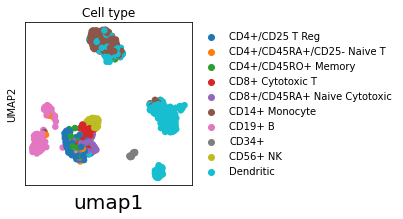

In [144]:
# Set title with the title parameter
# Return Axes to further modify the plot
ax = sc.pl.umap(adata, color="bulk_labels", title="Cell type", show=False)
# Modify xlabel
_ = ax.set_xlabel("umap1", fontsize=20)

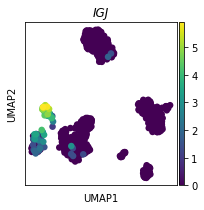

In [146]:
# Make title italic
ax = sc.pl.umap(adata, color="IGJ", show=False)
_ = ax.set_title("IGJ", style="italic")

/Users/karin.hrovatin/Documents/GitHub/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


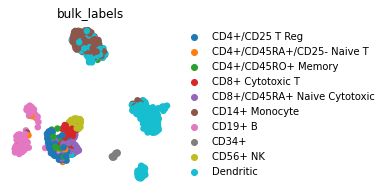

In [74]:
# Transparent background and no borders/axis labels with frameon=False
sc.pl.umap(adata, color="bulk_labels", frameon=False)

We can also change appearance (e.g color) of individual axis labels. This may be of special interest for plots like dotplot where we show multiple genes or cell groups and we want to highlight some of them.

Dotplot axes: {'mainplot_ax': <AxesSubplot: >, 'size_legend_ax': <AxesSubplot: title={'center': 'Fraction of cells\nin group (%)'}>, 'color_legend_ax': <AxesSubplot: title={'center': 'Mean expression\nin group'}>}


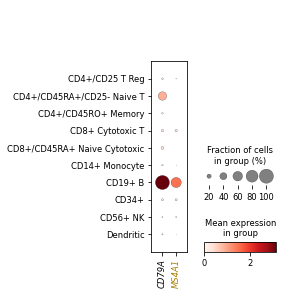

In [148]:
dp = sc.pl.dotplot(adata, ["CD79A", "MS4A1"], "bulk_labels", show=False)
# All Axes used in dotplot
print("Dotplot axes:", dp)
# Select the Axes object that contains the subplot of interest
ax = dp["mainplot_ax"]
# Loop through ticklabels and make them italic
for l in ax.get_xticklabels():
    l.set_style("italic")
    g = l.get_text()
    # Change settings (e.g. color) of certain ticklabels based on their text (here gene name)
    if g == "MS4A1":
        l.set_color("#A97F03")

(legends)=
### Customizing legends

We can define order of groups in `scanpy` legend by setting order of groups (`categories`) in the corresponding `obs` column in the `pandas` `DataFrame`.

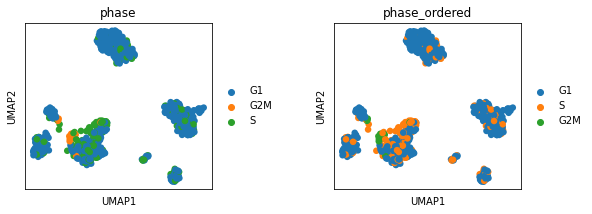

In [39]:
# The default ordering of cell cycle phases is alphabetical
# To ensure that the ordering corresponds to cell cycle define order of categories;
# this should include all categories in the corresponding pandas table column
phases = ["G1", "S", "G2M"]
adata.obs["phase_ordered"] = pd.Categorical(
    values=adata.obs.phase, categories=phases, ordered=True
)
sc.pl.umap(adata, color=["phase", "phase_ordered"], wspace=0.5)
# This just removes the newly added ordered column from adata as we do not need it below
adata.obs.drop("phase_ordered", axis=1, inplace=True)

Change the `Legend` title and move the `Legend` to a different location

/Users/karin.hrovatin/Documents/GitHub/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


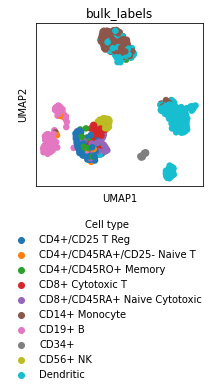

In [14]:
fig = sc.pl.umap(adata, color=["bulk_labels"], return_fig=True)
ax = fig.axes[0]
ax.legend_.set_title("Cell type")
# Change Legend location
ax.legend_.set_bbox_to_anchor((-0.2, -0.7))

Make a customized `Legend` by replacing the `Legend` instance in the plot. 

In case we want to add multiple `Legend` instances we need to use `plt.gca().add_artist(legend)` (shown in one of the below sections).

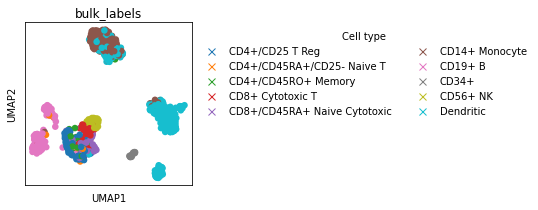

In [151]:
from matplotlib.lines import Line2D

fig = sc.pl.umap(adata, color=["bulk_labels"], return_fig=True)
ax = fig.axes[0]
# Remove original Legend
ax.legend_.remove()
# Make new Legend
l1 = ax.legend(
    # Add Legend element for each color group
    handles=[
        # Instead of Line2D we can also use other matplotlib objects, such as Patch, etc.
        Line2D(
            [0],
            [0],
            marker="x",
            color=c,
            lw=0,
            label=l,
            markerfacecolor=c,
            markersize=7,
        )
        # Color groups in adata
        for l, c in zip(
            list(adata.obs.bulk_labels.cat.categories), adata.uns["bulk_labels_colors"]
        )
    ],
    # Customize Legend outline
    # Remove background
    frameon=False,
    # Make more Legend columns
    ncols=2,
    # Change location to not overlap with the plot
    bbox_to_anchor=(1, 1),
    # Set title
    title="Cell type",
)

(marks)=
### Marking objects on the plot
We can plot ontop of already created plots to mark objects. 

Here we show how to encircle a single object on the plot and then add a new `Legend` to explain the mark.

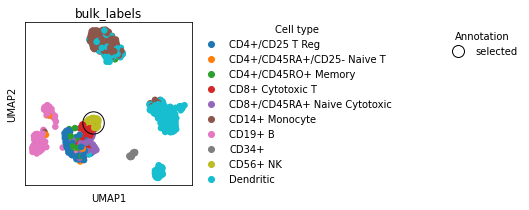

In [153]:
fig, ax = plt.subplots(figsize=(3, 3))
sc.pl.umap(adata, color=["bulk_labels"], ax=ax, show=False)

# Encircle part of the plot

# Find location on the plot where circle should be added
location_cells = adata[adata.obs.bulk_labels == "CD56+ NK", :].obsm["X_umap"]
x = location_cells[:, 0].mean()
y = location_cells[:, 1].mean()
size = 1.5  # Set circle size
# Plot circle
circle = plt.Circle((x, y), size, color="k", clip_on=False, fill=False)
ax.add_patch(circle)

# Add annother Legend for the mark

# Save the original Legend
l1 = ax.get_legend()
l1.set_title("Cell type")
# Make a new Legend for the mark
l2 = ax.legend(
    handles=[
        Line2D(
            [0],
            [0],
            marker="o",
            color="k",
            markerfacecolor="none",
            markersize=12,
            markeredgecolor="k",
            lw=0,
            label="selected",
        )
    ],
    frameon=False,
    bbox_to_anchor=(3, 1),
    title="Annotation",
)
# Add back the original Legend which was overwritten by the new Legend
_ = plt.gca().add_artist(l1)

We can also use external packages, such as `adjustText`, to help us mark objects on plots. 

`adjustText` enables annotation of multiple nearby plot locations while minimising text overlap. 

Axes: Axes(0.146628,0.15;0.568915x0.73)


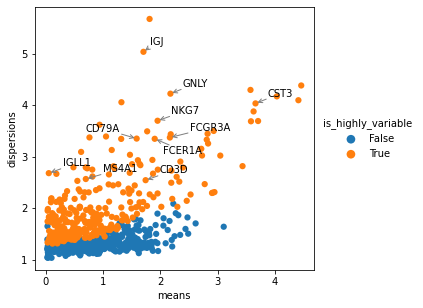

In [33]:
# Package used for adding well aligned labels on the plot
from adjustText import adjust_text

with plt.rc_context({"figure.figsize": (5, 5)}):
    x = "means"
    y = "dispersions"
    color = "is_highly_variable"
    adata.var["is_highly_variable"] = (
        adata.var["highly_variable"].astype(bool).astype(str)
    )
    ax = sc.pl.scatter(adata, x=x, y=y, color=color, show=False)
    print("Axes:", ax)
    # Move plot title from Axes to Legend
    ax.set_title("")
    ax.get_legend().set_title(color)

    # Labels

    # Select genes to be labeled
    texts = []
    genes = [
        "CD79A",
        "MS4A1",
        "FCER1A",
        "CST3",
        "FCGR3A",
        "GNLY",
        "NKG7",
        "IGLL1",
        "IGJ",
        "CD3D",
    ]
    for gene in genes:
        # Position of object to be marked
        x_loc = adata.var.at[gene, x]
        y_loc = adata.var.at[gene, y]
        # Text color
        color_point = "k"
        texts.append(ax.text(x_loc, y_loc, gene, color=color_point, fontsize=10))

    # Label selected genes on the plot
    _ = adjust_text(
        texts,
        expand_points=(2, 2),
        arrowprops=dict(arrowstyle="->", color="gray", lw=1),
        ax=ax,
    )

(colors)=
### A note on colors
Here we show how to define colors in `scanpy` and collected some recommendations on color palettes.

#### Discrete palettes

We can define colors for individual categories in `scanpy` with a `dictionary`. 

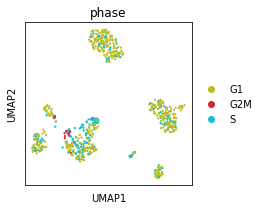

In [29]:
sc.pl.umap(
    adata,
    color="phase",
    s=20,
    palette={"S": "tab:cyan", "G1": "tab:olive", "G2M": "tab:red"},
)

While `matplotlib` offers various discrete palettes, it may be hard to find large palettes where colors can be easily distinguished. Tools such as [glasbey](https://github.com/lmcinnes/glasbey) enable creation of large discrete palettes where colors can be visually well distinguished. It also supports [hierarchical palettes](https://glasbey.readthedocs.io/en/latest/creating_block_palettes.html).

#### Continous palettes
For non-centered values we recommend [virids palettes](https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html) as they are perceptually uniform and colorblind friendly. For centered values we recommend [diverging palettes](https://matplotlib.org/stable/tutorials/colors/colormaps.html), where the center of the palette should be set to match the center value (e.g. 0).

We can center a diverging palette in `scanpy` with `vcenter`. Alternatively, we can use `vmin` and `vmax` to make the palette symmetric.

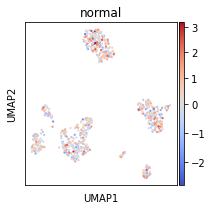

In [66]:
# Center palette with vcenter

# Make mock column for plotting, here we use random values from normal distribution
loc = 0
adata.obs["normal"] = np.random.normal(loc=loc, size=adata.shape[0])

# Center at mean (loc) of the distribution with vcenter parameter
sc.pl.umap(adata, color="normal", cmap="coolwarm", s=20, vcenter=loc)
adata.obs.drop("normal", axis=1, inplace=True)

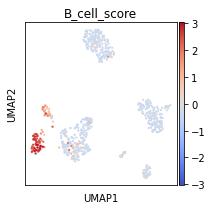

In [64]:
# Make symmetric palette with vmin and vmax

# Make mock column for plotting, here we use B cell score
sc.tl.score_genes(adata, ["CD79A", "MS4A1"], score_name="B_cell_score")

# To make a symmetric palette centerd around 0 we set vmax to maximal absolut value and vmin to
# the negative value of maxabs
maxabs = max(abs(adata.obs["B_cell_score"]))
sc.pl.umap(
    adata, color="B_cell_score", cmap="coolwarm", s=20, vmin=-maxabs, vmax=maxabs
)
adata.obs.drop("B_cell_score", axis=1, inplace=True)

`matplotlib` also supports [custom](https://matplotlib.org/stable/tutorials/colors/colormapnorms.html) color palettes with scaling (e.g. log), value range normalisation, centering, and custom color combinations or dynamic ranges.

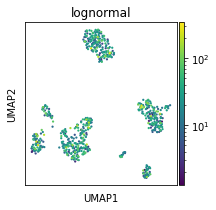

In [125]:
# Log-scaled palette

# Make mock column with log-normally distirbuited values
adata.obs["lognormal"] = np.random.lognormal(3, 1, adata.shape[0])

# Log scaling of the palette
norm = mcolors.LogNorm()
sc.pl.umap(adata, color="lognormal", s=20, norm=norm)

adata.obs.drop("lognormal", axis=1, inplace=True)

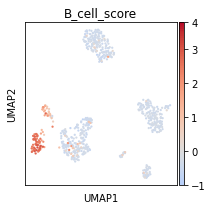

In [112]:
# Centered non-symmetric palette

# Make mock column for plotting, here we use B cell score
sc.tl.score_genes(adata, ["CD79A", "MS4A1"], score_name="B_cell_score")


# Palette normalization with centering and adapted dynamic range to correspond to
# the distance of vmin and vmax from the cenetr
# Adapted from https://stackoverflow.com/a/50003503
class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        value = np.array(value).astype(float)
        normalized_min = max(
            0.0,
            0.5
            * (1.0 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))),
        )
        normalized_max = min(
            1.0,
            0.5
            * (1.0 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))),
        )
        normalized_mid = 0.5
        x, y = (
            [self.vmin, self.midpoint, self.vmax],
            [normalized_min, normalized_mid, normalized_max],
        )
        return np.ma.masked_array(np.interp(value, x, y))


# Add padding arround vmin and vmax as Colorbar sets value limits to round numbers below and
# above the vmin and vmax, respectively, which means that they can not be assigned the correct
# color with our nomalisation function that is limited to vmin and vmax
# However, this padding reduces the dynamic range as we set a broad padding and
# then later discard values that are not needed for the rounding up and down
# of the vmin and vmax on the Colorbar, respectively
vmin = adata.obs["B_cell_score"].min()
vmax = adata.obs["B_cell_score"].max()
vpadding = (vmax - vmin) * 0.2
norm = MidpointNormalize(vmin=vmin - vpadding, vmax=vmax + vpadding, midpoint=0)
# Plot umap
fig = sc.pl.umap(
    adata,
    color="B_cell_score",
    cmap="coolwarm",
    s=20,
    norm=norm,
    return_fig=True,
    show=False,
)
# Adjust Colorbar ylim to be just outside of vmin,vmax and not far outside of this range
# as the padding we set initially may be too broad
cmap_yticklabels = np.array([t._y for t in fig.axes[1].get_yticklabels()])
fig.axes[1].set_ylim(
    max(cmap_yticklabels[cmap_yticklabels < vmin]),
    min(cmap_yticklabels[cmap_yticklabels > vmax]),
)

adata.obs.drop("B_cell_score", axis=1, inplace=True)

#### Colorblind friendly palettes

There are different resources that allow creation of colorblind friendly palettes. Example python packages are continous [virids palettes](https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html) and discrete [bokeh](https://docs.bokeh.org/en/latest/docs/reference/palettes.html) palettes. Some tools like [this one](https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40) also show how your discrete palette is perceived with different types of color blindness.

## UMAP
This section shows some `umap` (and `embedding`) specific tips.

(umap-subset)=
### Coloring cell subset
Here we show how we can plot all cells as a background and then plot on top indivdual cell groups in color.

We can color-in only specific cell groups when using categorical colors with the `groups` parameter.

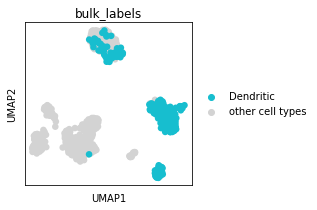

In [154]:
ax = sc.pl.umap(adata, color=["bulk_labels"], groups=["Dendritic"], show=False)

# We can change the 'NA' in the legend that represents all cells outside of the
# specified groups
legend_texts = ax.get_legend().get_texts()
# Find legend object whose text is "NA" and change it
for legend_text in legend_texts:
    if legend_text.get_text() == "NA":
        legend_text.set_text("other cell types")

We can also plot continous values of an individual cell group. For this we need to first plot all cells as a background and then overlay the expression of the selected cell group.

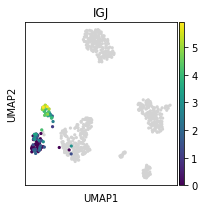

In [127]:
# Define dot size for all plot parts
dot_size = 40
# Plot all cells as background
ax = sc.pl.umap(adata, show=False, s=dot_size)
# Plot ontop expression of a single cell group by subsetting adata
sc.pl.umap(adata[adata.obs.bulk_labels == "CD19+ B", :], color="IGJ", ax=ax, s=dot_size)

(umap-order)=
### Cell ordering
`embedding` allows sorting based on continous value to plot cells with the highest score on top (parameter `sort_order`). However, for categorical values `embedding` currently does not offer special ordering parameters. Instead, the cells are plotted in the same order as they are stored in the `AnnData`. Thus, for example, when we concatente two `AnnData` objects of two batches and we want to visualise the location of batches, one of the batches will be plotted ontop of the other batch. Thus we first need to reorder cells to ensure that both batches will be visible.

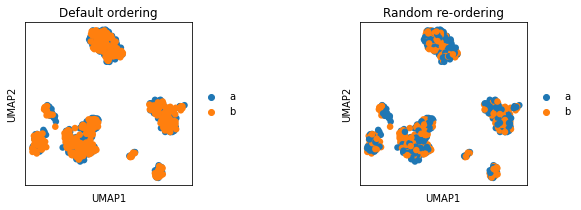

In [140]:
# Make two batches in the adata object for the plot example
adata.obs["batch"] = ["a"] * int(adata.shape[0] / 2) + ["b"] * (
    adata.shape[0] - int(adata.shape[0] / 2)
)

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
plt.subplots_adjust(wspace=1)
sc.pl.umap(adata, color="batch", ax=axs[0], title="Default ordering", show=False)
# Randomly order cells by making a random index and subsetting AnnData based on it
# Set a random seed to ensure that the cell ordering will be reproducible
np.random.seed(0)
random_indices = np.random.permutation(list(range(adata.shape[0])))
sc.pl.umap(
    adata[random_indices, :], color="batch", ax=axs[1], title="Random re-ordering"
)

(umap-embed)=
### Optimising UMAP layout <a class="anchor" id="umap-embed"></a>
UMAP layout can be modified to make cells located in more tight or dispersed structures. This can be regulated with the `sc.tl.umap` parameters `min_dist` and `spread`. Below we show UMAP exaples computed with different parameter combinations.

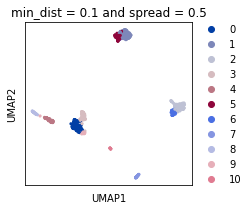

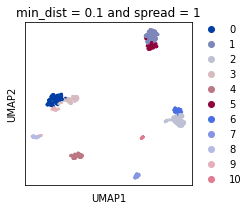

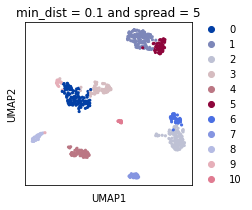

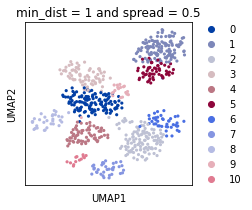

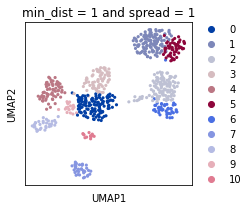

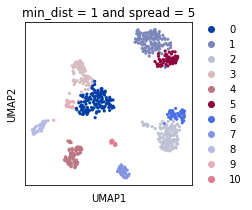

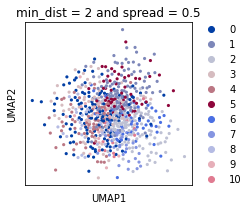

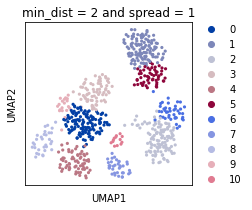

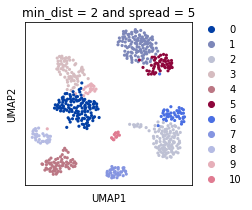

In [15]:
# Copy adata not to modify UMAP in the original adata object
adata_temp = adata.copy()
# Loop through different umap parameters, recomputting and replotting UMAP for each of them
for min_dist in [0.1, 1, 2]:
    for spread in [0.5, 1, 5]:
        param_str = " ".join(["min_dist =", str(min_dist), "and spread =", str(spread)])
        sc.tl.umap(adata_temp, min_dist=min_dist, spread=spread)
        # Display plot and then immediately close it to ensure that
        # we do not open too many plot windows at once
        g = sc.pl.umap(
            adata_temp,
            color=["louvain"],
            title=param_str,
            s=40,
            show=False,
            return_fig=True,
        )
        display(g)
        plt.close()
del adata_temp

## PAGA

In [8]:
sc.tl.paga(adata, groups="louvain")

(paga-prune)=
### Prune PAGA edges
Remove weak PAGA edges in the plot based on edge weight distribution. 

This is based on the assumption that most edge weights will be relatively weak and that we can therefore spot the few most interesting edges as the outliers of the distribution.

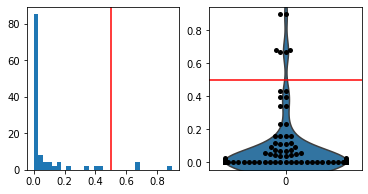

In [36]:
# Distribution of PAGA connectivities for determining the cutting threshold
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
paga_conn = adata.uns["paga"]["connectivities"].toarray().ravel()
a = axs[0].hist(paga_conn, bins=30)
sns.violinplot(paga_conn, ax=axs[1], inner=None)
sns.swarmplot(paga_conn, ax=axs[1], color="k")
thr = 0.5
_ = axs[1].axhline(thr, c="r")
_ = axs[0].axvline(thr, c="r")

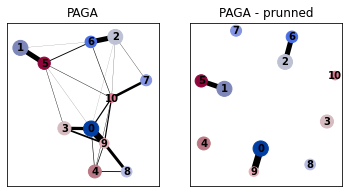

In [37]:
# Compare PAGA with and without prunning
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
sc.pl.paga(adata, ax=axs[0], title="PAGA", show=False)
sc.pl.paga(adata, ax=axs[1], title="PAGA - prunned", threshold=thr)

(paga-embed)=
### PAGA layout
The layout used in PAGA is optimised to correspond to the PAGA `connectivties` (edge weighs). However, sometimes we would wish to have a different layout. For this we can use the `pos` argument.

#### PAGA layout corresponding to UMAP
Set PAGA dot centers to the mean of the UMAP embedding values of cells from the corresponding groups.

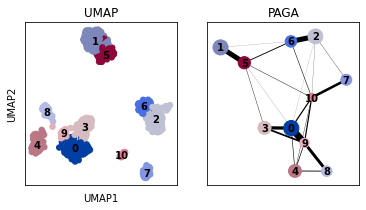

In [19]:
# Compare UMAP and PAGA layouts
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
sc.pl.umap(
    adata, color="louvain", ax=axs[0], show=False, title="UMAP", legend_loc="on data"
)
sc.pl.paga(adata, ax=axs[1], title="PAGA")

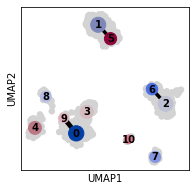

In [38]:
# Define PAGA positions based on the UMAP layout -
# for each cluster we use the mean of the UMAP positions from the cells in that cluster
pos = pd.DataFrame(adata.obsm["X_umap"], index=adata.obs_names)
pos["group"] = adata.obs[adata.uns["paga"]["groups"]]
pos = pos.groupby("group").mean()

# Plot UMAP in the background
ax = sc.pl.umap(adata, show=False)
# Plot PAGA ontop of the UMAP
sc.pl.paga(
    adata,
    color="louvain",
    threshold=thr,
    node_size_scale=1,
    edge_width_scale=0.7,
    pos=pos.values,
    random_state=0,
    ax=ax,
)